In [1]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: /Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis


In [2]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V3')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

In [3]:
### Image Insertion ###

f = nd2.ND2File(img_path)
image = to_8bit(f.asarray())

DAPI_stack = image[:,0,:,:].copy()
eGFP_stack = image[:,1,:,:].copy()
WGA_stack = image[:,2,:,:].copy()

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=90, channels=[0,0])

In [ ]:
# 1) Finding coordinates of cells
coords_3d = nuclei_centers_of_mass(DAPI_stack, DAPI_masks)

# 2) Removing local outliers from mask
filtered_coords_3d, filtered_idxs = remove_outliers_local(coords_3d)
DAPI_masks = extract_masks(DAPI_masks, filtered_idxs)


ValueError: too many values to unpack (expected 2)

# Removing local outliers

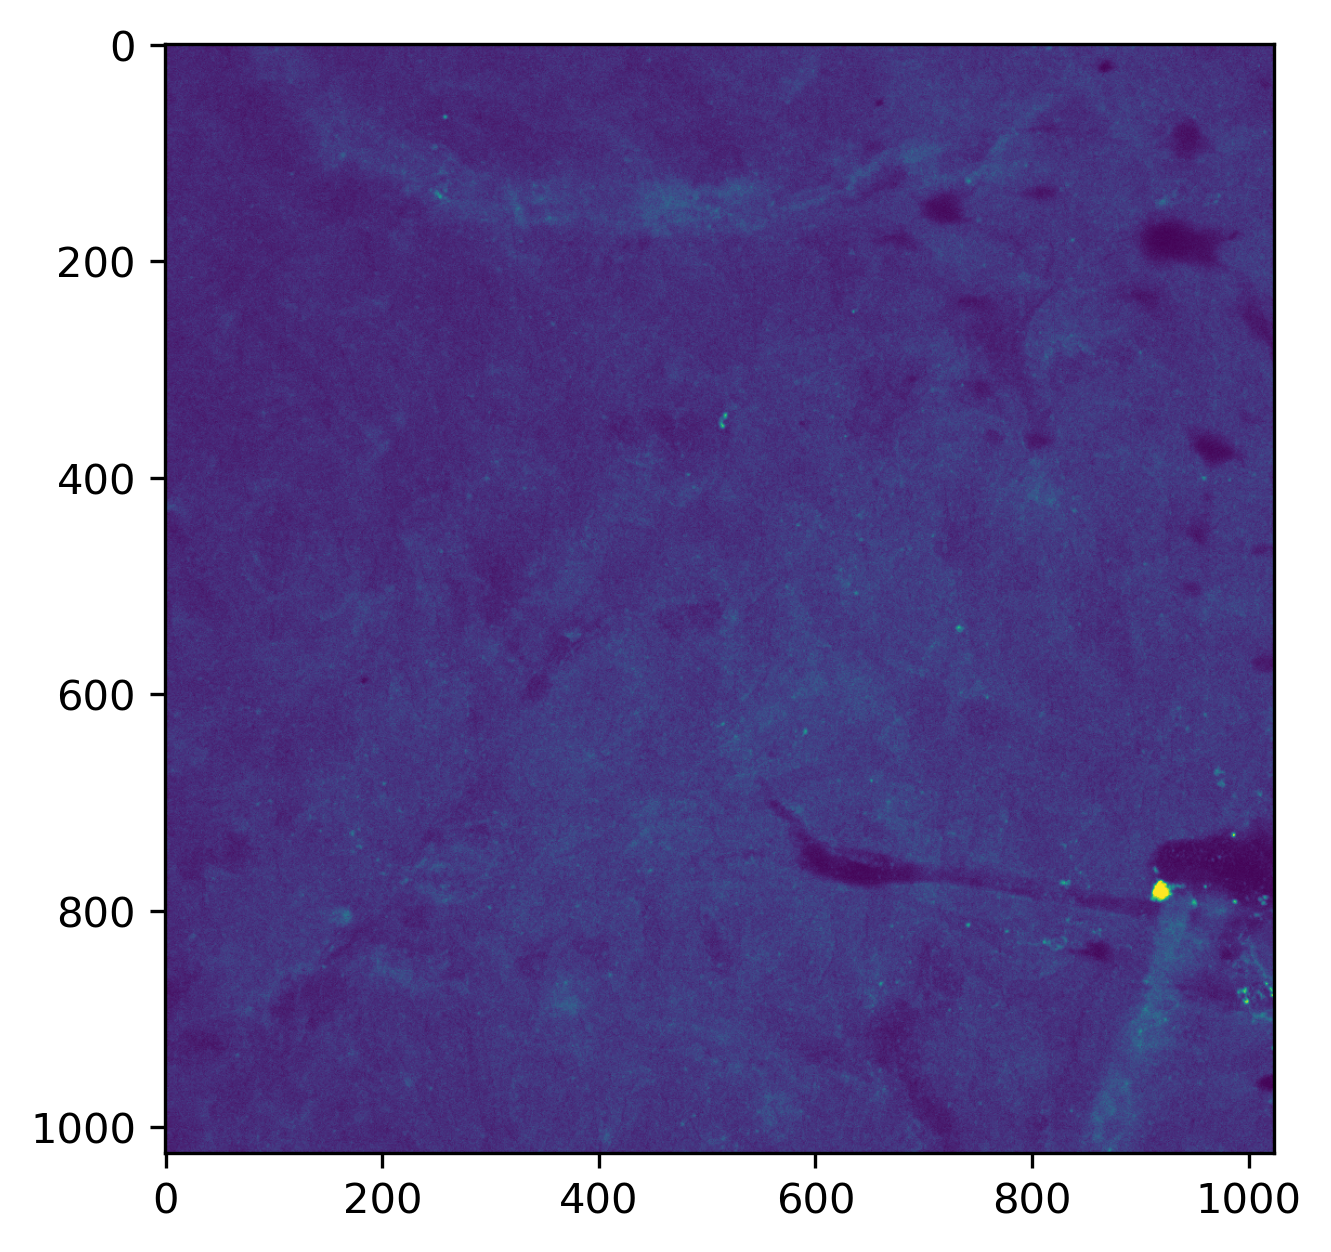

In [ ]:
nuclei_zs = nuclei_slices(DAPI_stack, DAPI_masks)
z_intensities = np.sum(WGA_stack, axis=(1, 2))
ILM_layer = int(np.argmax(z_intensities))
nuclei_layer = np.sum(nuclei_zs) // len(nuclei_zs)
vein_axon_layer = int((ILM_layer + nuclei_layer) / 2)

overlay = plot.mask_overlay(WGA_stack[ILM_layer, :, :], DAPI_masks)

plt.imshow(WGA_stack[ILM_layer, :, :])
